In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pylab as plt
import scipy.integrate
import scipy.stats

In [2]:
def lotka_volterra(y, t, alpha, beta, gamma, delta):
    u, v = y
    return [alpha * u - beta * u * v, -gamma * v + delta * u * v]

def solve_lotka_volterra(times, alpha, beta, gamma, delta, u_0, v_0):
    s = scipy.integrate.odeint(lotka_volterra, [u_0, v_0], times, args=(alpha, beta, gamma, delta))
    return pd.DataFrame({'t': times, 'u': s[:, 0], 'v': s[:, 1]})

In [3]:
df_analytic = solve_lotka_volterra(np.linspace(0, 25, 1001),
    0.55, 0.028, 0.84, 0.026, 33, 6)

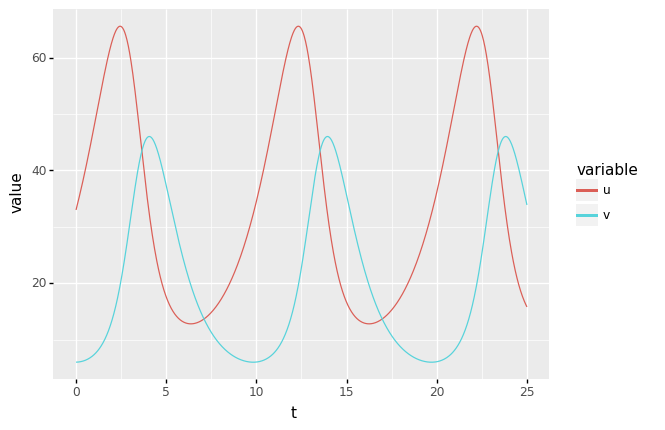

<ggplot: (8739701101629)>

In [4]:
(
    ggplot(pd.melt(df_analytic, id_vars='t'), aes(x='t', y='value', colour='variable')) +
    geom_line()
)

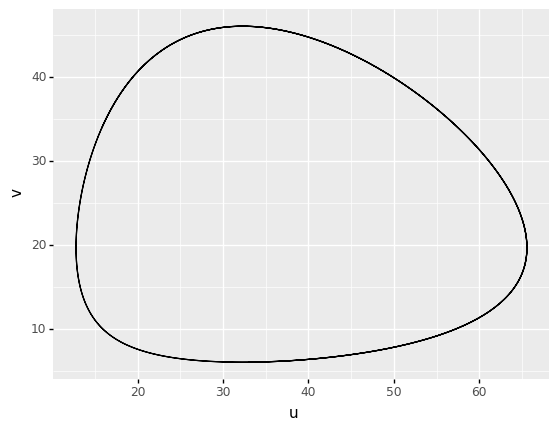

<ggplot: (8739698888421)>

In [5]:
(
    ggplot(df_analytic, aes(x='u', y='v')) +
    geom_path()
)

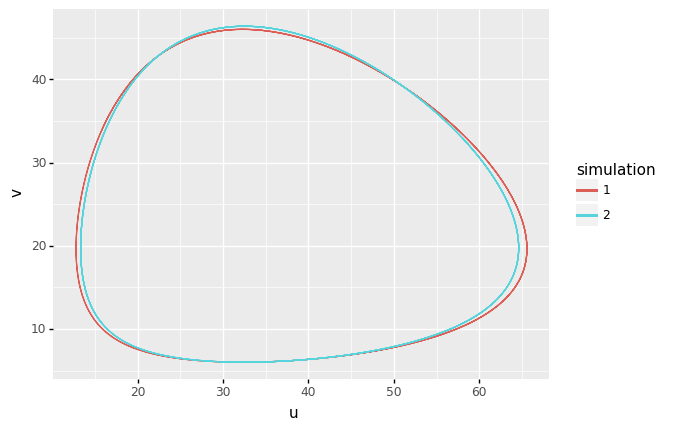

<ggplot: (8739698892153)>

In [6]:
df_analytic2 = solve_lotka_volterra(df_analytic['t'],
    0.79, 0.04, 1.3, 0.04, 33, 6)
df_analytic['simulation'] = '1'
df_analytic2['simulation'] = '2'
df_analytic_1_2 = pd.concat([df_analytic, df_analytic2])
(
    ggplot(df_analytic_1_2, aes(x='u', y='v', colour='simulation')) +
    geom_path()
)

In [7]:
def apply_noise(df, sigma_u, sigma_v):
    df.insert(len(df.columns), 'u_tilde', 0); df.insert(len(df.columns), 'v_tilde', 0)
    for i in range(len(df)):
        df.at[i, 'u_tilde'] = scipy.stats.lognorm.rvs(scale=df['u'][i], s=sigma_u, size=1)
        df.at[i, 'v_tilde'] = scipy.stats.lognorm.rvs(scale=df['v'][i], s=sigma_v, size=1)
    return df

times = np.arange(0, 25, 1)
df1 = solve_lotka_volterra(times, 0.55, 0.028, 0.84, 0.026, 33, 6)
df1 = apply_noise(df1, 0.25, 0.25)
df1['simulation'] = 1
df2 = solve_lotka_volterra(times, 0.9, 0.04, 1.3, 0.04, 33, 6)
df2 = apply_noise(df2, 0.25, 0.25)
df2['simulation'] = 2

df_obs = pd.concat([df1, df2])

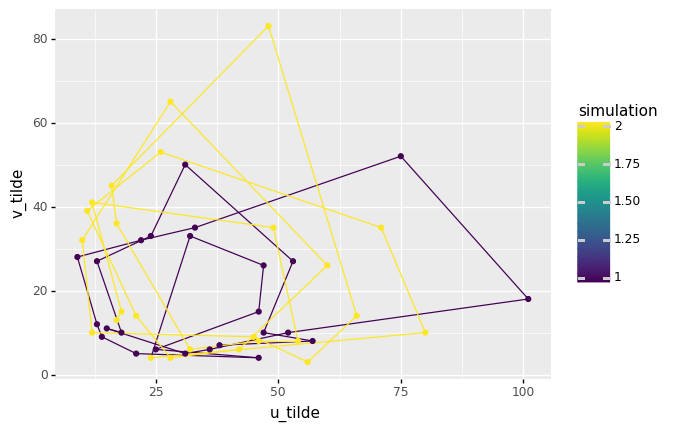

<ggplot: (8739698855048)>

In [8]:
(
    ggplot(df_obs, aes(x='u_tilde', y='v_tilde', colour='simulation')) +
    geom_path() +
    geom_point()
)

In [9]:
def lotka_volterra_u_loglikelihood(df_obs, alpha, beta, gamma, delta, u_0, v_0, sigma_u, sigma_v):
    df = solve_lotka_volterra(df_obs['t'], alpha, beta, gamma, delta, u_0, v_0)
    log_p = 0
    for i in range(len(df_obs['t'])):
        log_p += scipy.stats.lognorm.logpdf(df_obs['u_tilde'][i], scale=df['u'][i], s=sigma_u)
        log_p += scipy.stats.lognorm.logpdf(df_obs['v_tilde'][i], scale=df['v'][i], s=sigma_v)
    return log_p

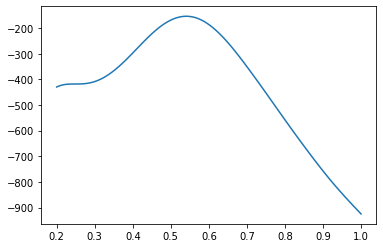

In [10]:
alpha = np.linspace(0.2, 1, 100)
log_likelihoods = np.zeros_like(alpha)
for i in range(len(alpha)):
    log_likelihoods[i] = lotka_volterra_u_loglikelihood(df_obs.query('simulation == 1'),
        alpha[i], 0.028, 0.84, 0.026, 33, 6, 0.25, 0.25)
plt.plot(alpha, log_likelihoods)
plt.show()

In [11]:
import pints

class LotkaVolterraLogPDF(pints.LogPDF):
    def __init__(self, df_obs, u0=33, v0=6, sigma_u=0.25, sigma_v=0.25):
        self._df_obs = df_obs
        self._u0 = u0
        self._v0 = v0
        self._sigma_u = sigma_u
        self._sigma_v = sigma_v
    
    def __call__(self, x):
        df_obs = self._df_obs
        u0 = self._u0
        v0 = self._v0
        sigma_u = self._sigma_u
        sigma_v = self._sigma_v
        return lotka_volterra_u_loglikelihood(df_obs, x[0], x[1], x[2], x[3],
            u0, v0, sigma_u, sigma_v)
    
    def n_parameters(self):
        return 4

In [12]:
model = LotkaVolterraLogPDF(df_obs.query('simulation == 1'))
nchains = 4
xs = [[0.6, 0.02, 1, 0.03]]*4
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

mcmc.set_max_iterations(2000)
mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0         0          0:00.1
2     12     0         0         0         0          0:00.1
3     16     0         0.25      0.25      0          0:00.2


/home/sabsr3/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


20    84     0.0952    0.0952    0.0952    0.0952     0:00.8
40    164    0.0732    0.0488    0.0732    0.0732     0:01.5
60    244    0.0656    0.0492    0.0492    0.082      0:02.2
80    324    0.0617    0.037     0.0494    0.0741     0:02.8
100   404    0.0495    0.0396    0.0396    0.0594     0:03.5
120   484    0.0413    0.0331    0.0331    0.0496     0:04.2
140   564    0.0355    0.0284    0.0284    0.0567     0:04.9
160   644    0.0311    0.0248    0.0248    0.0559     0:05.6
180   724    0.0276    0.0221    0.0221    0.0497     0:06.2
Initial phase completed.
200   804    0.0249    0.0199    0.0199    0.0448     0:06.9
220   884    0.0498    0.0498    0.0452    0.0633     0:07.6
240   964    0.0871    0.0747    0.0913    0.083      0:08.3
260   1044   0.119     0.107     0.107     0.111      0:08.9
280   1124   0.13879   0.128     0.128     0.13879    0:09.6
300   1204   0.15      0.133     0.136     0.153      0:10.3
320   1284   0.152648  0.15      0.146     0.174      0:10.9

In [13]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.52    0.05    0.44    0.48   0.52   0.56   0.63     1.07    133.38  2.04
param 2  0.03    0.00    0.02    0.03   0.03   0.03   0.04     1.06    159.99  2.45
param 3  0.87    0.08    0.72    0.81   0.86   0.93   1.01     1.10    134.68  2.06
param 4  0.03    0.00    0.02    0.03   0.03   0.03   0.03     1.08    202.36  3.09


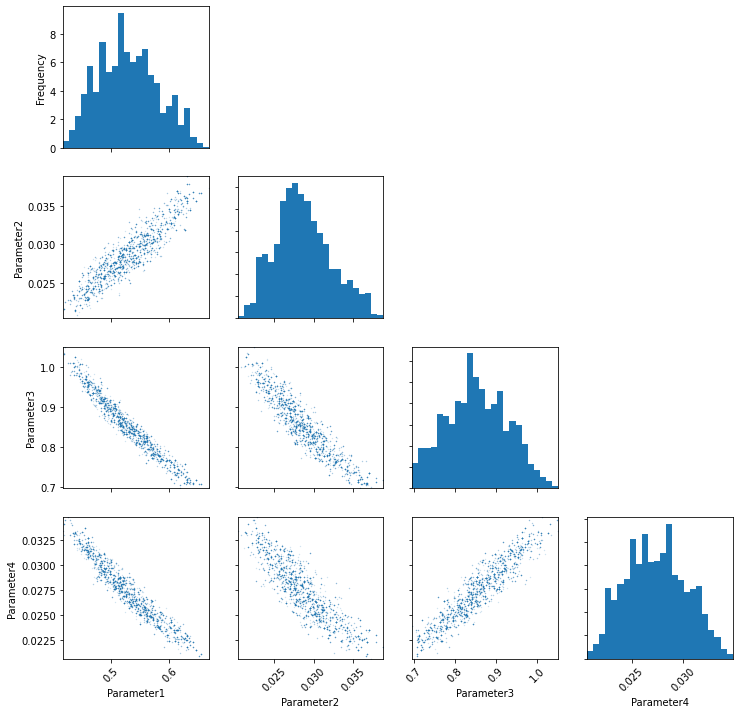

In [14]:
import pints.plot

pints.plot.pairwise(np.vstack(chains[:, 1000:]), kde=False)
plt.show()

In [15]:
n_samples = 100

chains_sample = np.vstack(chains[:, 1000:])
idx = np.random.randint(len(chains_sample), size=n_samples)
chains_sample = chains_sample[idx,]
times = np.linspace(0, 25, 1001)
sample_df = pd.DataFrame()

for i in range(n_samples):
    tmp = solve_lotka_volterra(times,
        chains_sample[i, 0], chains_sample[i, 1],
        chains_sample[i, 2], chains_sample[i, 3],
        33, 6)
    tmp['replicate'] = i
    sample_df = sample_df.append(tmp)

In [16]:
df_obs['type'] = 'observations'
sample_df['type'] = 'simulations'
sample_df['simulation'] = 1
df_all = pd.concat([df_obs, sample_df])

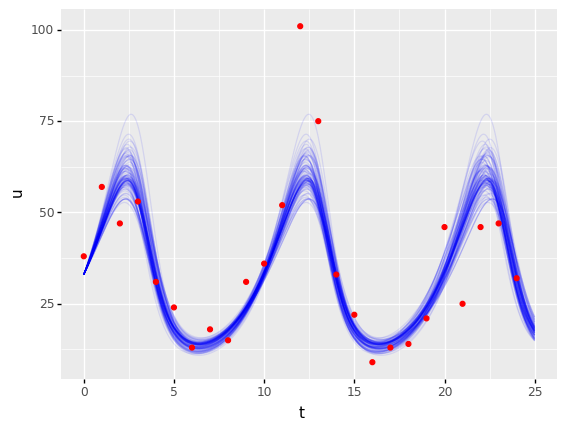

<ggplot: (8739698784723)>

In [17]:
(
    ggplot() +
    geom_line(aes(x='t', y='u', group='replicate'), alpha=0.1,
        data=df_all.query('type=="simulations" and simulation==1'), colour='blue') +
    geom_point(aes(x='t', y='u_tilde'), colour='red',
        data=df_all.query('type=="observations" and simulation==1'))
)

In [18]:
log_prior = pints.UniformLogPrior(
    [0,0,0,0],
    [2,0.1,2.0,0.2])
xs = log_prior.sample(nchains)
mcmc = pints.MCMCController(model, nchains, xs, method=pints.HaarioBardenetACMC)

mcmc.set_max_iterations(2000)

mcmc.set_initial_phase_iterations(200)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     8      0         0.5       0         0          0:00.1
2     12     0.333     0.333     0.333     0.333      0:00.1
3     16     0.5       0.25      0.25      0.25       0:00.2
20    84     0.238     0.429     0.333     0.19       0:00.9
40    164    0.195122  0.341     0.293     0.244      0:01.7
60    244    0.18      0.23      0.23      0.18       0:02.5
80    324    0.16      0.185     0.173     0.136      0:03.3
100   404    0.149     0.149     0.158     0.109      0:04.0
120   484    0.124     0.132     0.149     0.0909     0:04.8
140   564    0.106383  0.113     0.128     0.078      0:05.5
160   644    0.0932    0.0994    0.112     0.0745     0:06.3
180   724    0.0884    0.0884    0.0994    0.0663     0:07.1
Initial phase completed.
200   804    0.0796    0.

/home/sabsr3/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


420   1684   0.211     0.209     0.221     0.204      0:15.5
440   1764   0.209     0.209     0.211     0.204      0:16.2
460   1844   0.204     0.2       0.202     0.195      0:16.9
480   1924   0.202     0.191     0.195     0.193      0:17.6
500   2004   0.2       0.184     0.188     0.19       0:18.3
520   2084   0.198     0.177     0.18      0.184261   0:19.0
540   2164   0.198     0.17      0.174     0.179      0:19.7
560   2244   0.201426  0.164     0.169     0.184      0:20.4
580   2324   0.203     0.158     0.169     0.188      0:21.1
600   2404   0.208     0.153     0.166     0.19       0:21.8
620   2484   0.208     0.151     0.164     0.193      0:22.5
640   2564   0.206     0.151     0.161     0.193      0:23.2
660   2644   0.209     0.154     0.16      0.192      0:23.8
680   2724   0.204     0.159     0.163     0.191      0:24.5
700   2804   0.2       0.163     0.167     0.194      0:25.2
720   2884   0.198     0.164     0.171     0.2        0:25.9
740   2964   0.2       0

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.57    0.52    0.07    0.19   0.32   0.97   1.68     1.55    17.35  0.25
param 2  0.05    0.06    0.00    0.01   0.02   0.09   0.18     1.55    17.22  0.25
param 3  2.32    1.77    0.79    1.06   1.71   2.56   6.52     2.49    16.64  0.24
param 4  0.07    0.05    0.02    0.04   0.05   0.08   0.19     2.46    16.91  0.25


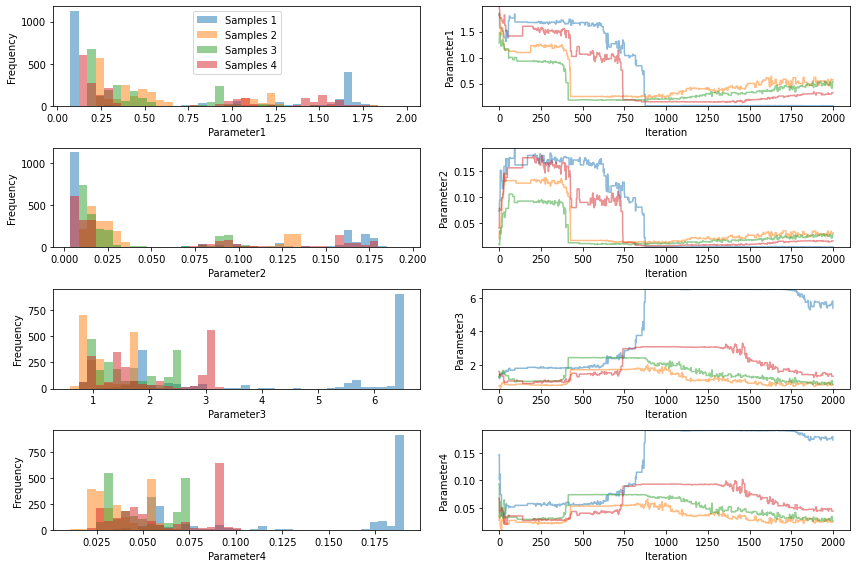

In [19]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time())
print(results)

pints.plot.trace(chains)
plt.show()

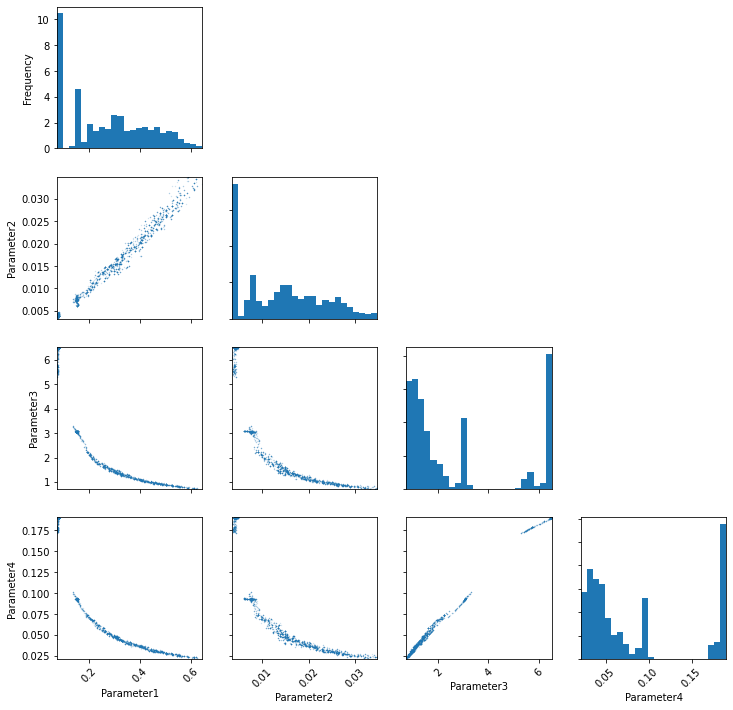

In [20]:
pints.plot.pairwise(np.vstack(chains[:, 1000:]), kde=False)
plt.show()

In [21]:
n_samples = 100

chains_sample = np.vstack(chains[:, 1000:])
idx = np.random.randint(len(chains_sample), size=n_samples)
chains_sample = chains_sample[idx,]
times = np.linspace(0, 25, 1001)
sample_df = pd.DataFrame()

for i in range(n_samples):
    tmp = solve_lotka_volterra(times,
        chains_sample[i, 0], chains_sample[i, 1],
        chains_sample[i, 2], chains_sample[i, 3],
        33, 6)
    tmp['replicate'] = i
    sample_df = sample_df.append(tmp)

In [22]:
df_obs['type'] = 'observations'
sample_df['type'] = 'simulations'
sample_df['simulation'] = 1
df_all = pd.concat([df_obs, sample_df])

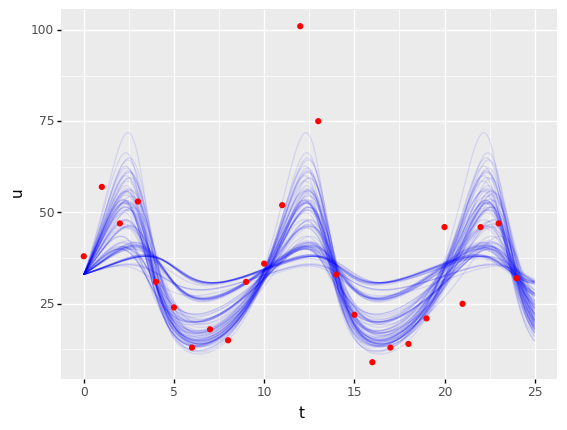

<ggplot: (8739698892057)>

In [23]:
(
    ggplot() +
    geom_line(aes(x='t', y='u', group='replicate'), alpha=0.1,
        data=df_all.query('type=="simulations" and simulation==1'), colour='blue') +
    geom_point(aes(x='t', y='u_tilde'), colour='red',
        data=df_all.query('type=="observations" and simulation==1'))
)